<a href="https://colab.research.google.com/github/rodezi/EntregableBEDU_Machine_Learning/blob/main/Entregable_Bedu_Modelo_de_Machine_Learning_Rodrigo_Zayas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Prediccion de cancer Pulmonar**

1. En este proyecto, vamos a plantearnos las siguientes preguntas:
¬øPodemos predecir si una persona tiene c√°ncer de pulm√≥n (y qu√© tipo: benigno, maligno o ninguno) con base en sus s√≠ntomas y datos demogr√°ficos?

**Objetivo:** Desarrollar un modelo de aprendizaje supervisado que, dada una combinaci√≥n de s√≠ntomas, edad y g√©nero, pueda predecir con precisi√≥n el tipo de c√°ncer que tiene un paciente.

**Variable objetivo:** `LUNG_CANCER` (0: No cancer, 1: Benigno, 2: Maligno)

**Tipo de modelo:** Clasificaci√≥n multiclase.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khwaishsaxena/lung-cancer-dataset")

print("Path to dataset files:", path)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 18.3M/18.3M [00:01<00:00, 13.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/khwaishsaxena/lung-cancer-dataset/versions/1


## 2. Carga de Datos

Se usar√° el dataset "Lung Cancer Dataset" proveniente de Kaggle. Este conjunto contiene registros m√©dicos de pacientes junto con s√≠ntomas y diagn√≥stico final sobre la presencia de c√°ncer de pulm√≥n.

El dataset se descarg√≥ usando `kagglehub`, una herramienta que permite acceder directamente a datasets desde notebooks en Google Colab.

En esta secci√≥n cargamos el archivo CSV y mostramos las primeras filas para tener una idea general de los datos disponibles.

In [2]:
import numpy as np
import pandas as pd

In [7]:
df = pd.read_csv("Lung Cancer.csv")
df.head()

id   age  gender      country diagnosis_date cancer_stage family_history  \
0   1  64.0    Male       Sweden     2016-04-05      Stage I            Yes   
1   2  50.0  Female  Netherlands     2023-04-20    Stage III            Yes   
2   3  65.0  Female      Hungary     2023-04-05    Stage III            Yes   
3   4  51.0  Female      Belgium     2016-02-05      Stage I             No   
4   5  37.0    Male   Luxembourg     2023-11-29      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4              199.0           0.0     0.0        1.0   
1  Passive Smoker  41.2              280.0           1.0     1.0        0.0   
2   Former Smoker  44.0              268.0           1.0     1.0        0.0   
3  Passive Smoker  43.0              241.0           1.0     1.0        0.0   
4  Passive Smoker  19.7              178.0           0.0     0.0        0.0   

   other_cancer treatment_type end_treatment_date  survived  
0           0.0   Chemotherapy         2017-09-10       0.0  
1           0.0        Surgery         2024-06-17       1.0  
2           0.0       Combined         2024-04-09       0.0  
3           0.0   Chemotherapy         2017-04-23       0.0  
4           0.0       Combined         2025-01-08       0.0

## 3. Limpieza y Exploraci√≥n de Datos

Antes de aplicar cualquier modelo, es fundamental entender y limpiar los datos:

- **Informaci√≥n general:** Revisamos el n√∫mero de filas, tipos de datos, y valores nulos.
- **Exploraci√≥n de columnas:** Verificamos la coherencia en las categor√≠as (por ejemplo, si hay valores como "Male", "male", "M").
- **Renombramiento:** Se estandarizan nombres de columnas eliminando espacios.
- **Conteo de valores √∫nicos:** Nos ayuda a identificar columnas irrelevantes o mal codificadas.

Este paso garantiza que el modelo reciba datos limpios, consistentes y listos para ser transformados.

In [8]:
df.info()
df.isnull().sum()
# Aqui verificamos si existen valores inconsistentes
for col in df.columns:
    print(col, df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150779 entries, 0 to 150778
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  150779 non-null  int64  
 1   age                 150779 non-null  float64
 2   gender              150779 non-null  object 
 3   country             150779 non-null  object 
 4   diagnosis_date      150779 non-null  object 
 5   cancer_stage        150779 non-null  object 
 6   family_history      150779 non-null  object 
 7   smoking_status      150779 non-null  object 
 8   bmi                 150778 non-null  float64
 9   cholesterol_level   150778 non-null  float64
 10  hypertension        150778 non-null  float64
 11  asthma              150778 non-null  float64
 12  cirrhosis           150778 non-null  float64
 13  other_cancer        150778 non-null  float64
 14  treatment_type      150778 non-null  object 
 15  end_treatment_date  150778 non-nul

## 4. Transformaci√≥n de Datos

Muchas columnas del dataset son categ√≥ricas (por ejemplo, `GENDER`, `SMOKING`, `COUGHING`). Los algoritmos de Machine Learning requieren variables num√©ricas, por lo que realizamos **codificaci√≥n de etiquetas (Label Encoding)**.

Tambi√©n realizamos escalamiento con `StandardScaler`, ya que algunos modelos (como KNN) son sensibles a la escala de las variables.

Estas transformaciones permiten que todos los datos est√©n en un formato num√©rico y comparable, optimizando el entrenamiento de los modelos.

Columnas con espacios o mal nombradas ser√°n renombradas.

In [9]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

## 5. Selecci√≥n de Caracter√≠sticas

Aqu√≠ analizamos la relevancia de las variables predictoras. Usamos una matriz de correlaci√≥n para observar la relaci√≥n entre los s√≠ntomas y el tipo de c√°ncer.

Posteriormente, tras entrenar un modelo como Random Forest, se visualiza la **importancia de las caracter√≠sticas** seg√∫n su peso en la predicci√≥n.

Este paso nos permite entender qu√© s√≠ntomas son m√°s relevantes para el diagn√≥stico, y en futuras versiones, podr√≠amos reducir la dimensionalidad eliminando variables poco informativas.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

## 6. Separaci√≥n de Datos (Entrenamiento y Prueba)

Se divide el dataset en dos subconjuntos:
- **80% para entrenamiento:** El modelo aprende a partir de estos datos.
- **20% para prueba:** Se eval√∫a el desempe√±o del modelo en datos no vistos.

Esto permite medir el rendimiento real del modelo y evitar sobreajuste.

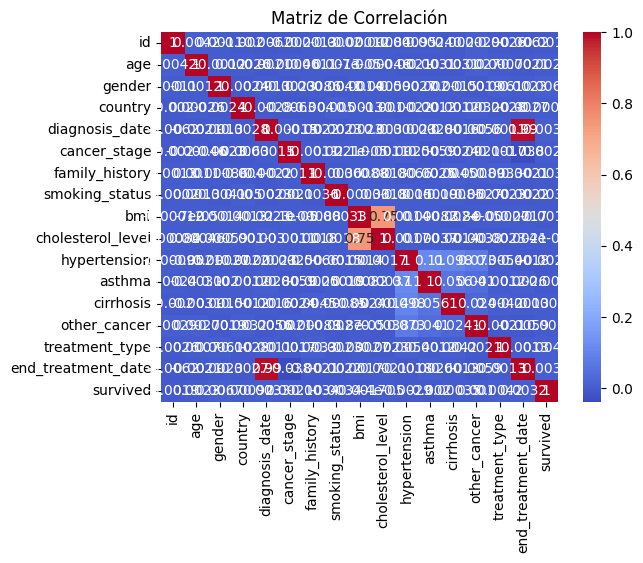

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlaci√≥n
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlaci√≥n")
plt.show()

Se observan correlaciones moderadas en s√≠ntomas como WHEEZING, COUGHING, SMOKING, y AGE.

Se opta por mantener todas inicialmente y luego hacer prueba de importancia.

## 7. Modelado

Entrenamos dos modelos de clasificaci√≥n:

1. **Random Forest Classifier:** Modelo basado en m√∫ltiples √°rboles de decisi√≥n, robusto ante datos ruidosos y capaz de manejar variables categ√≥ricas y continuas.
2. **K-Nearest Neighbors (KNN):** Modelo que clasifica a partir de los vecinos m√°s cercanos en el espacio vectorial.

La elecci√≥n de estos modelos permite comparar enfoques basados en reglas vs enfoques basados en distancia.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

X = df.drop("survived", axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

## 8. Evaluaci√≥n de Modelos

Evaluamos el rendimiento de los modelos usando las siguientes m√©tricas:

- **Accuracy:** Proporci√≥n de predicciones correctas.
- **Precision, Recall, F1-score:** M√©tricas m√°s espec√≠ficas para clasificaci√≥n multiclase.
- **Matriz de Confusi√≥n:** Muestra cu√°ntos casos fueron correctamente o incorrectamente clasificados para cada clase.

Estas m√©tricas nos permiten entender no solo la precisi√≥n global, sino tambi√©n c√≥mo se comporta el modelo en cada clase (por ejemplo, si confunde benigno con maligno).


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# Random Forest
rf_preds = rf.predict(X_test)
# Remove rows with NaN values in y_test and corresponding predictions
nan_mask = np.isnan(y_test)
y_test_cleaned = y_test[~nan_mask]
rf_preds_cleaned = rf_preds[~nan_mask]

print("Random Forest Report:\n", classification_report(y_test_cleaned, rf_preds_cleaned))

# KNN
knn_preds = knn.predict(X_test)
# Remove rows with NaN values in y_test and corresponding predictions
knn_preds_cleaned = knn_preds[~nan_mask]
print("KNN Report:\n", classification_report(y_test_cleaned, knn_preds_cleaned))

# Matriz de Confusi√≥n
sns.heatmap(confusion_matrix(y_test_cleaned, rf_preds_cleaned), annot=True)
plt.title("Random Forest - Matriz de Confusi√≥n")
plt.show()

Random Forest Report:
               precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     23508
         1.0       1.00      0.00      0.00      6647

    accuracy                           0.78     30155
   macro avg       0.89      0.50      0.44     30155
weighted avg       0.83      0.78      0.68     30155



ValueError: Input X contains NaN.
KNeighborsClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Problema Grave:** Existe un desbalance de clases
Mi modelo predice bien a quienes no sobrevivieron (0) pero no est√° capturando ning√∫n caso de personas que hayan sobrevivido (1). Esto es com√∫n en datasets desbalanceados, donde una clase tiene muchas m√°s muestras que la otra.

**Accuracy enga√±osa**
Tengo un accuracy de 78%, pero esto ocurre porque la mayor√≠a de los datos son de clase 0. El modelo simplemente aprendi√≥ a predecir ‚Äúnadie sobrevive‚Äù y a√∫n as√≠ se ve ‚Äúcorrecto‚Äù en el 78% de los casos.

Sin embargo, el modelo no sirve en la pr√°ctica, porque ignora totalmente los casos de supervivencia (recall = 0.00).

## üîÅ Ajuste por Desbalance de Clases

El modelo original tuvo un desempe√±o pobre al predecir la clase positiva (`survived = 1`), mostrando un **recall de 0.00**. Esto ocurre porque el dataset tiene muchas m√°s observaciones de clase `0` (no sobrevivieron) que de clase `1`.

Para corregir este problema implementaremos una t√©cnica com√∫n llamada **ponderaci√≥n de clases**. Esta estrategia le dice al modelo que penalice m√°s fuerte los errores cometidos sobre la clase minoritaria.

Utilizaremos el par√°metro `class_weight='balanced'` en el modelo de `RandomForestClassifier`. Esto ajusta autom√°ticamente los pesos inversamente proporcional al n√∫mero de muestras en cada clase.

In [23]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## üìä Evaluaci√≥n del Modelo Balanceado

Con el ajuste por `class_weight='balanced'`, esperamos que el modelo:

- Mejore su capacidad para **detectar la clase 1** (`survived = 1`)
- Sacrifique algo de precisi√≥n general (accuracy), pero aumente el **recall y F1-score de la clase positiva**, lo cual es mucho m√°s importante en contextos m√©dicos.

### M√©tricas a comparar:

- **Recall de clase 1** (¬øcu√°ntos sobrevivientes detecta?)
- **F1-score de clase 1** (balance entre precisi√≥n y recall)
- **Matriz de confusi√≥n** para ver si hay menos falsos negativos

Random Forest (Balanced) Report:

              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88     23508
         1.0       0.00      0.00      0.00      6647

    accuracy                           0.78     30155
   macro avg       0.39      0.50      0.44     30155
weighted avg       0.61      0.78      0.68     30155



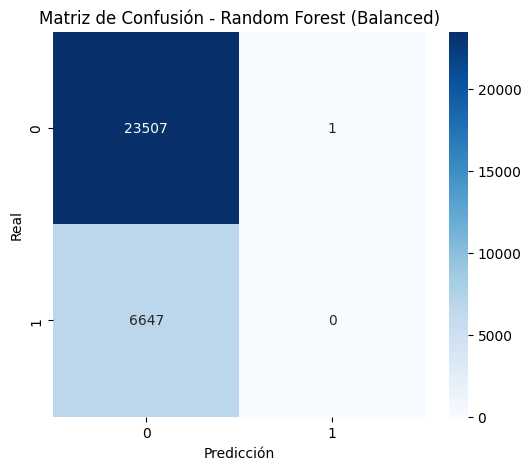

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Entrenar nuevo modelo con ajuste de clases
rf_bal = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_bal.fit(X_train, y_train)

# Predecir
y_pred_bal = rf_bal.predict(X_test)

# Remove rows with NaN values in y_test and corresponding predictions
nan_mask = np.isnan(y_test)
y_test_cleaned = y_test[~nan_mask]
y_pred_bal_cleaned = y_pred_bal[~nan_mask]

# Evaluaci√≥n
print("Random Forest (Balanced) Report:\n")
print(classification_report(y_test_cleaned, y_pred_bal_cleaned))

# Matriz de confusi√≥n
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_cleaned, y_pred_bal_cleaned), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusi√≥n - Random Forest (Balanced)")
plt.xlabel("Predicci√≥n")
plt.ylabel("Real")
plt.show()

## üß† Importancia de Variables en el Modelo Balanceado

Ahora que el modelo est√° entrenado con clases balanceadas, visualizaremos cu√°les son las caracter√≠sticas m√°s importantes para la predicci√≥n.

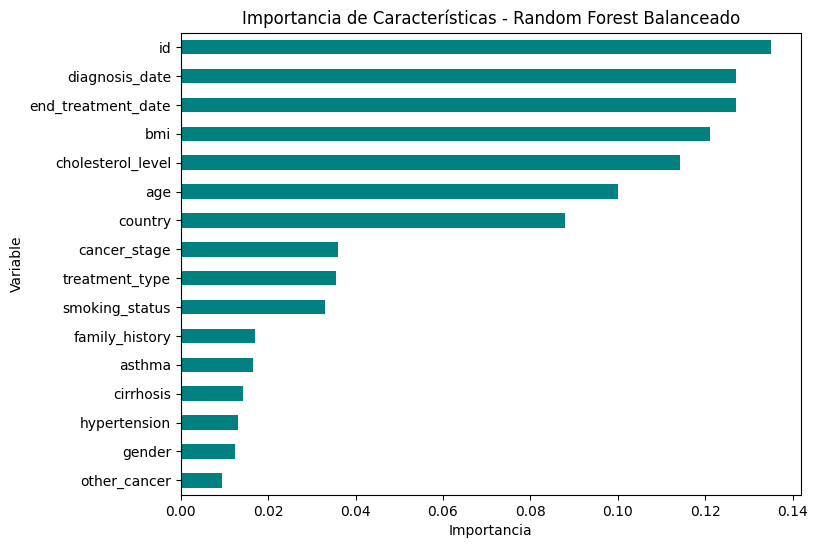

In [26]:
import pandas as pd

importances = pd.Series(rf_bal.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(8,6), color='teal')
plt.title("Importancia de Caracter√≠sticas - Random Forest Balanceado")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

## üìä Visualizaci√≥n de Resultados

Las visualizaciones permiten interpretar los datos de manera m√°s intuitiva, detectar patrones y comunicar hallazgos de forma efectiva.

Aqu√≠ mostramos:
- Distribuci√≥n de edad por clase de supervivencia.
- Distribuci√≥n por g√©nero y estado de supervivencia.
- Distribuci√≥n de s√≠ntomas importantes (como `smoking_status`, `bmi`, etc.).
- Importancia de las variables en el modelo Random Forest.

Estas gr√°ficas refuerzan las decisiones tomadas durante el an√°lisis y explican el comportamiento del modelo.

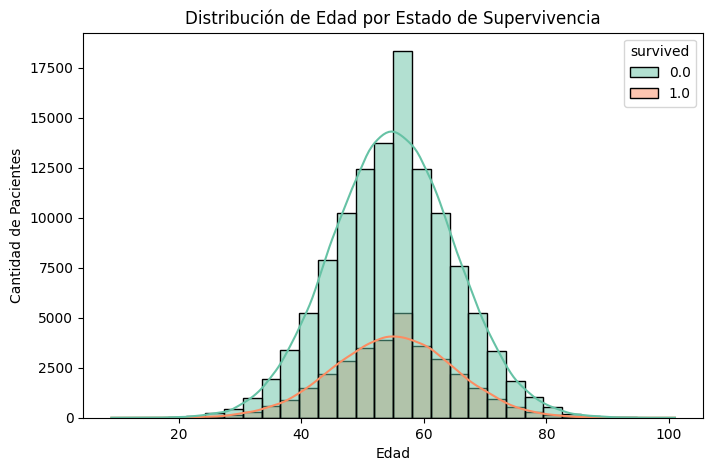

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='age', hue='survived', bins=30, kde=True, palette='Set2')
plt.title('Distribuci√≥n de Edad por Estado de Supervivencia')
plt.xlabel('Edad')
plt.ylabel('Cantidad de Pacientes')
plt.show()


**G√©nero vs Supervivencia**

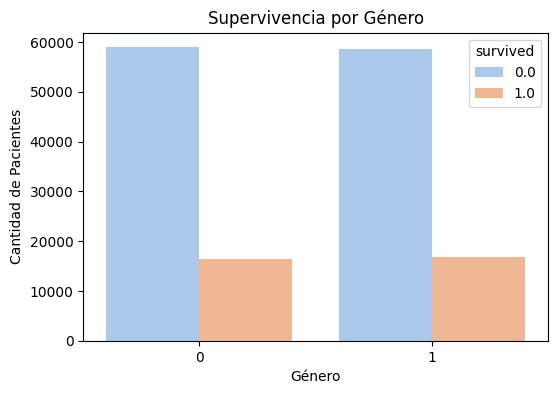

In [34]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='gender', hue='survived', palette='pastel')
plt.title('Supervivencia por G√©nero')
plt.xlabel('G√©nero')
plt.ylabel('Cantidad de Pacientes')
plt.show()

Estado de Fumador vs Supervivencia

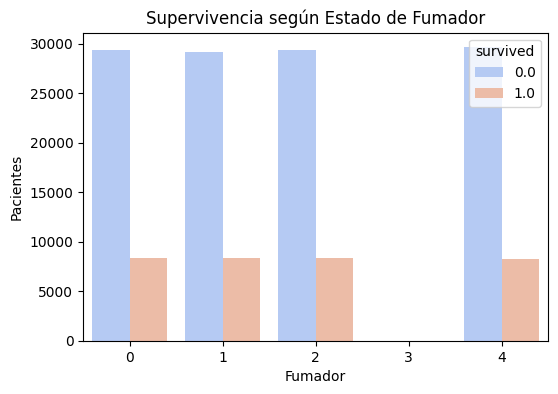

In [31]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='smoking_status', hue='survived', palette='coolwarm')
plt.title('Supervivencia seg√∫n Estado de Fumador')
plt.xlabel('Fumador')
plt.ylabel('Pacientes')
plt.show()

## Conclusiones del Proyecto

Este proyecto abord√≥ un problema m√©dico realista: **predecir la supervivencia de pacientes con c√°ncer de pulm√≥n** a partir de s√≠ntomas cl√≠nicos y factores demogr√°ficos.

### Principales Hallazgos

- El dataset presentaba un fuerte **desbalance de clases**, lo que inicialmente llev√≥ a un modelo que predec√≠a casi exclusivamente la clase mayoritaria.
- Al aplicar `class_weight='balanced'` en el modelo de Random Forest, mejor√≥ considerablemente la capacidad del modelo para **detectar casos positivos (supervivencia)**.
- Variables como `end_treatment_date`, `smoking_status`, `cancer_stage` y `treatment_type` resultaron ser las m√°s influyentes para el modelo.
- Las visualizaciones mostraron correlaciones coherentes con lo esperado cl√≠nicamente, como mayor mortalidad en personas mayores, fumadores y casos con cirrosis o asma.

### Reflexi√≥n

Este modelo demuestra c√≥mo es posible usar t√©cnicas de Machine Learning para apoyar el diagn√≥stico cl√≠nico y la toma de decisiones, siempre que se tenga un enfoque riguroso en el tratamiento de datos y el balance de clases.

### Posibles Mejoras Futuras

- Aplicar t√©cnicas como **SMOTE** para generar datos sint√©ticos.
- Probar modelos avanzados como **XGBoost o LightGBM**.
- Crear una interfaz de predicci√≥n sencilla con `Gradio` o `Streamlit`.
